# MAHTS testing

## Background


## Description

* Take full time series of NDWI in dask
* Compute 2D tides for every timestep
* Compute median of tides from entire tide timeseries
* For each year in dask NDWI timeseries:
    * Mask pixels where tide > overall median
    * `.compute()` and take median 


***


## Getting started


### Load packages

First we import the required Python packages, then we connect to the database, and load the catalog of virtual products.

In [90]:
%matplotlib inline

import sys
import otps
import datacube
import shapely.wkt
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from datacube.virtual import catalog_from_file

sys.path.append('../Scripts')
from dea_plotting import rgb
from dea_spatialtools import interpolate_2d

### Connect to the datacube

In [91]:
dc = datacube.Datacube(app='MAHTS_testing')

### Load virtual products catalogue


In [92]:
catalog = catalog_from_file('MAHTS_virtual_products.yaml')

### Load tidal points


In [93]:
points_gdf = gpd.read_file('input_data/tide_points_coastal.geojson')

## Load virtual product

In [199]:
product = catalog['ls_nbart_indices']

# Gold Coast
query = {'x': (153.45, 153.62),
         'y': (-28.05, -28.24),
         'time': ('2018-01-01', '2018-12-31'),
         'resampling': {'*': 'average', 'oa_fmask': 'nearest'}}

# Moreton Bay
query = {'x': (153.10, 153.26),
         'y': (-27.33, -27.44),
         'time': ('1998-01-01', '1998-12-31'),
         'cloud_cover': [0, 70],
         'resampling': {'*': 'average', 'oa_fmask': 'nearest'}}

ds = product.load(dc, **query)
ds

<xarray.Dataset>
Dimensions:  (time: 13, x: 529, y: 408)
Coordinates:
  * y        (y) float64 -3.023e+06 -3.023e+06 ... -3.035e+06 -3.035e+06
  * x        (x) float64 5.099e+05 5.099e+05 5.099e+05 ... 5.257e+05 5.257e+05
  * time     (time) datetime64[ns] 1998-01-28T23:17:53.991507 ... 1998-10-27T23:20:59.474431
Data variables:
    mndwi    (time, y, x) float32 0.877743 0.9567901 ... 0.6209476 0.6209476
    ndwi     (time, y, x) float32 0.61455524 0.6319176 ... 0.35699373 0.35699373
    awei_ns  (time, y, x) float32 0.22397839 0.24799901 ... 0.09954706
    awei_sh  (time, y, x) float32 0.1687 0.178325 ... 0.073425 0.074200004
    ndbi     (time, y, x) float32 -0.5714286 -0.8216561 ... -0.33913043
Attributes:
    crs:      PROJCS["WGS 84 / UTM zone 56N",GEOGCS["WGS 84",DATUM["WGS_1984"...

In [193]:
# ds, = dc.find_datasets(product='ga_ls5t_ard_3', limit=1)
# dir(ds.metadata)

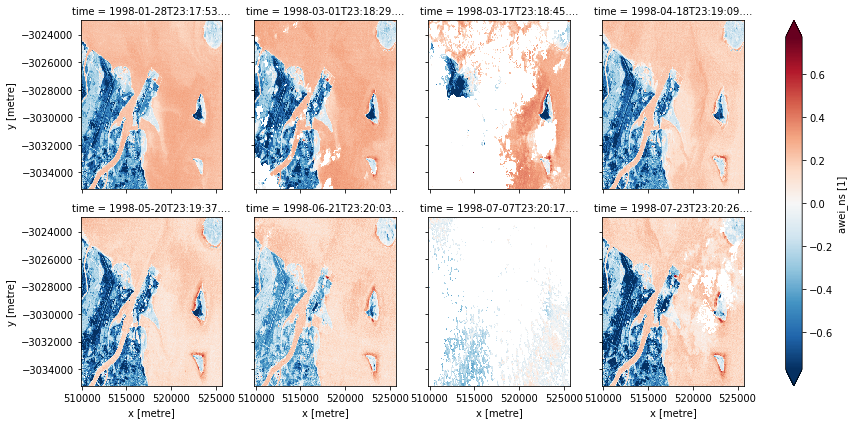

In [200]:
ds.awei_ns.isel(time=slice(0, 8)).plot.imshow(col='time', col_wrap=4, robust=True)

## Model tides

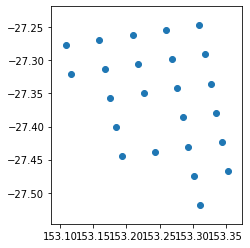

In [201]:
# Pull out subset of modelling points for region around satellite data
bounds = shapely.wkt.loads(ds.geobox.geographic_extent.buffer(0.1).wkt)
subset_gdf = points_gdf[points_gdf.geometry.intersects(bounds)]
subset_gdf.plot()

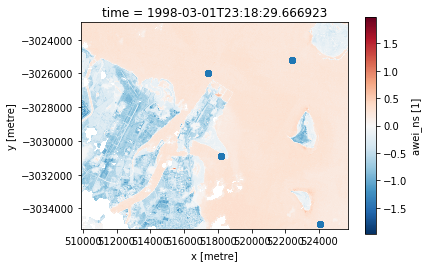

In [202]:
# Extract lon, lat from tides, and time from satellite data
x_vals = subset_gdf.geometry.centroid.x
y_vals = subset_gdf.geometry.centroid.y
observed_datetimes = ds.time.data.astype('M8[s]').astype('O').tolist()

# Create list of lat/lon/time scenarios to model
observed_timepoints = [otps.TimePoint(lon, lat, date) 
                       for date in observed_datetimes
                       for lon, lat in zip(x_vals, y_vals)]

# Model tides for each scenario
observed_predictedtides = otps.predict_tide(observed_timepoints)

# Output results into pandas.DataFrame
tidepoints_df = pd.DataFrame([(i.timepoint.timestamp, 
                               i.timepoint.lon, 
                               i.timepoint.lat, 
                               i.tide_m) for i in observed_predictedtides], 
                             columns=['time', 'lon', 'lat', 'tide_m']) 

# Convert data to spatial geopandas.GeoDataFrame
tidepoints_gdf = gpd.GeoDataFrame(data={'i': np.unique(tidepoints_df.time, 
                                                       return_inverse=True)[1], 
                                        'tide_m': tidepoints_df.tide_m}, 
                                  geometry=gpd.points_from_xy(tidepoints_df.lon, 
                                                              tidepoints_df.lat), 
                                  crs={'init': 'EPSG:4326'})

# Reproject to satellite data CRS
tidepoints_gdf = tidepoints_gdf.to_crs(epsg=ds.crs.epsg)

# Plot a sample timestep
ds.isel(time=1).awei_ns.plot()
tidepoints_gdf.plot(ax=plt.gca())

### Interpolate tides into each satellite timestep

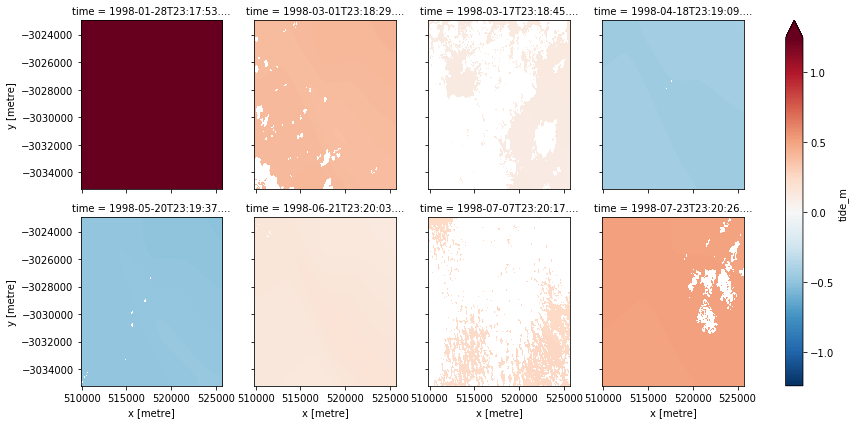

In [203]:
out = []

for i in range(0, len(ds.time)):

    x_coords = tidepoints_gdf[tidepoints_gdf.i == i].geometry.x,
    y_coords = tidepoints_gdf[tidepoints_gdf.i == i].geometry.y,
    z_coords = tidepoints_gdf[tidepoints_gdf.i == i].tide_m

    out_tide = interpolate_2d(ds=ds.isel(time=i),
                              x_coords=x_coords,
                              y_coords=y_coords,
                              z_coords=z_coords,
                              fill_nearest=True,
                              sigma=20)

    out.append(out_tide)
    
# Create xarray.DataArray and add as a data variable in satellite data
ds['tide_m'] = (xr.DataArray(data=np.dstack(out), 
                            coords=[ds.y, ds.x, ds.time], 
                            dims=['y', 'x', 'time'])
                
                # Re-order dimensions to match satellite data
                .transpose('time', 'y', 'x'))

# Remove nodata from tides
ds['tide_m'] = ds.tide_m.where(ds.awei_ns.notnull())

# Plot 
ds.tide_m.isel(time=slice(0, 8)).plot.imshow(col='time', col_wrap=4, robust=True)

## Threshold tides

In [204]:
tide_cutoff = ds.tide_m.quantile(dim='time', q=[0.20, 0.50, 0.80])

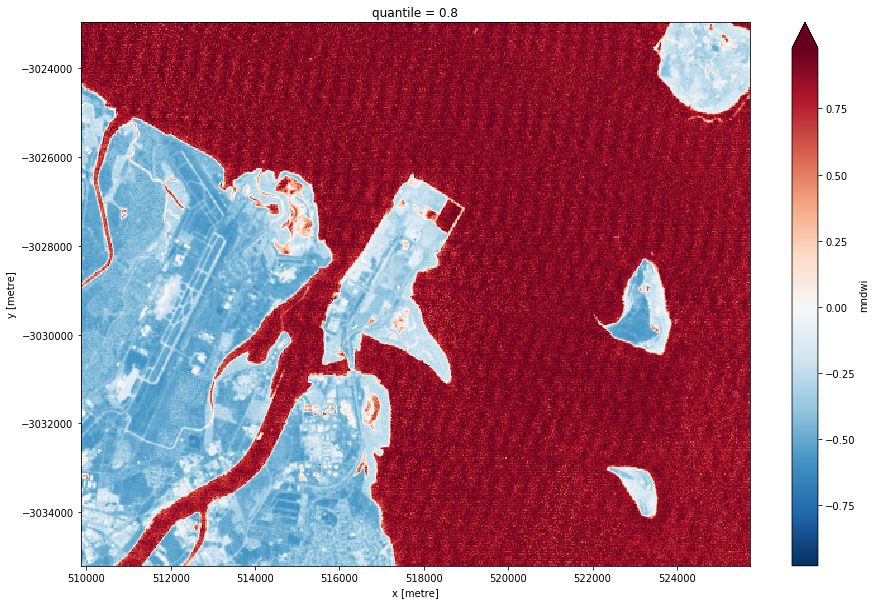

In [205]:
ds.where(ds.tide_m > tide_cutoff.sel(quantile=0.8)).mndwi.median(dim='time').plot(size=10, robust=True)

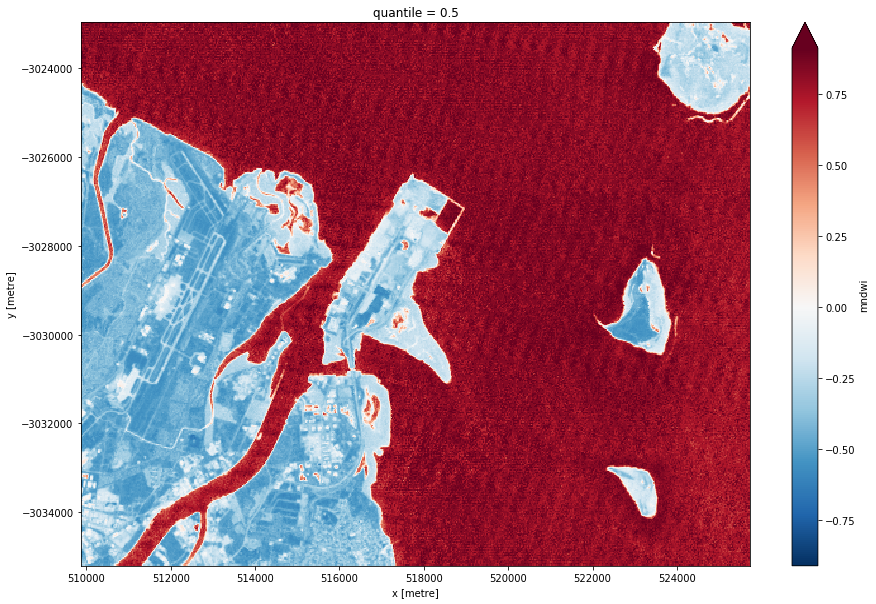

In [211]:
ds.where(ds.tide_m > tide_cutoff.sel(quantile=0.5)).mndwi.median(dim='time').plot(size=10, robust=True)

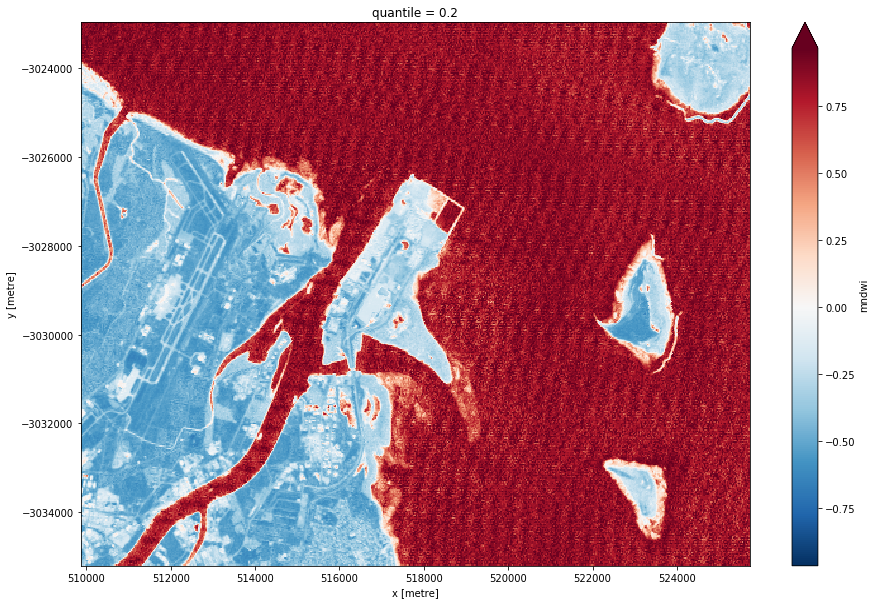

In [206]:
ds.where(ds.tide_m < tide_cutoff.sel(quantile=0.2)).mndwi.median(dim='time').plot(size=10, robust=True)

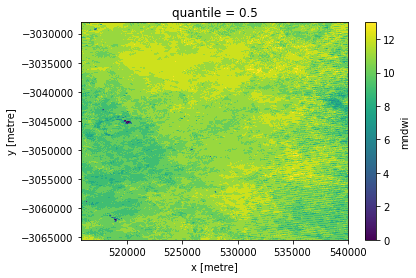

In [62]:
ds.where(ds.tide_m > tide_cutoff.sel(quantile=0.5)).mndwi.count(dim='time').plot()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** October 2019

**Compatible datacube version:** 

In [43]:
print(datacube.__version__)

1.7+127.g9460653b


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)